In [7]:
!pip install pmdarima

In [8]:
import os
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [9]:
dateparse = lambda dates: pd.to_datetime(dates, '%Y-%m-%d')
df=pd.read_csv('MSFT.csv',index_col='Date',parse_dates=['Date'])
df=df.dropna()

In [10]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,47894400
...,...,...,...,...,...,...
2023-10-03,320.829987,321.390015,311.209991,313.390015,313.390015,21033500
2023-10-04,314.029999,320.040009,314.000000,318.959991,318.959991,20720100
2023-10-05,319.089996,319.980011,314.899994,319.359985,319.359985,16965600


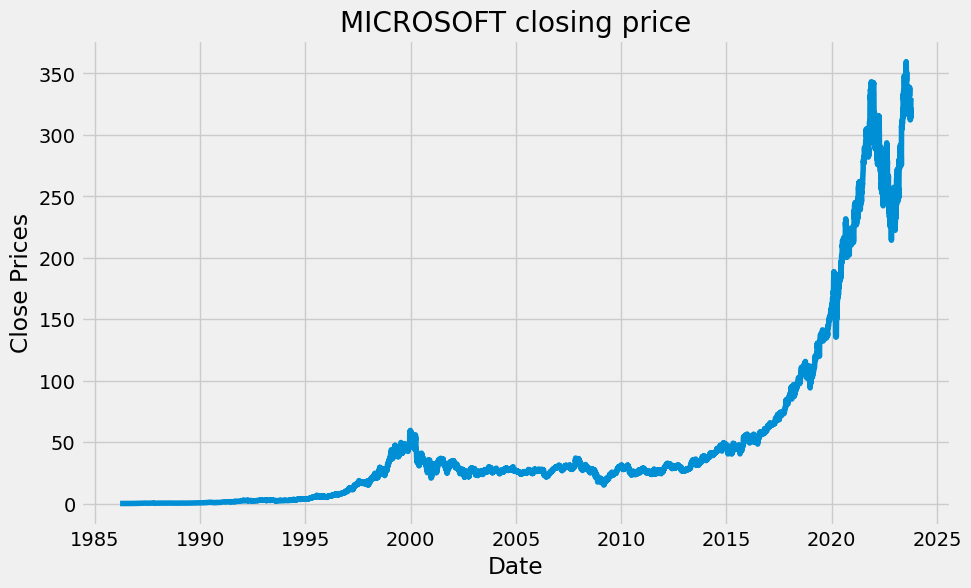

In [11]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('MICROSOFT closing price')
plt.show()

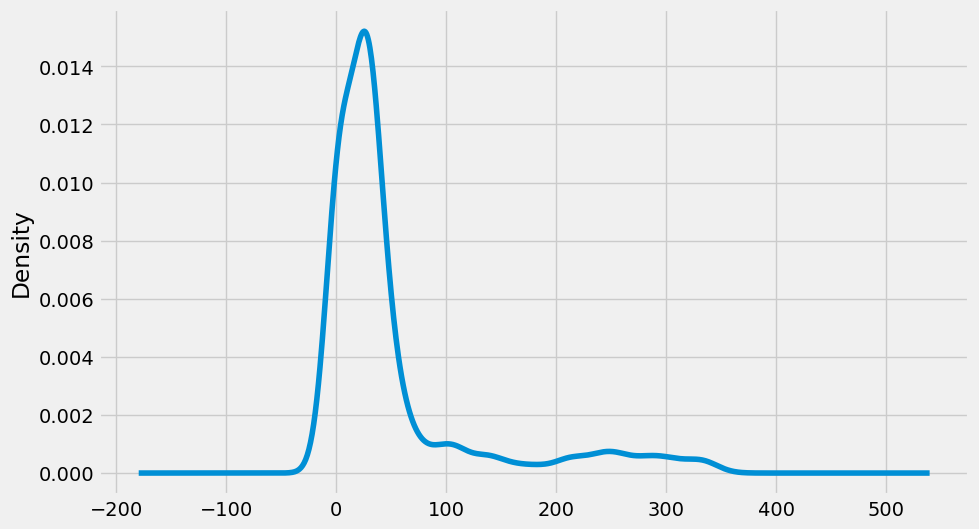

In [12]:
df['Close'].plot(kind='kde');

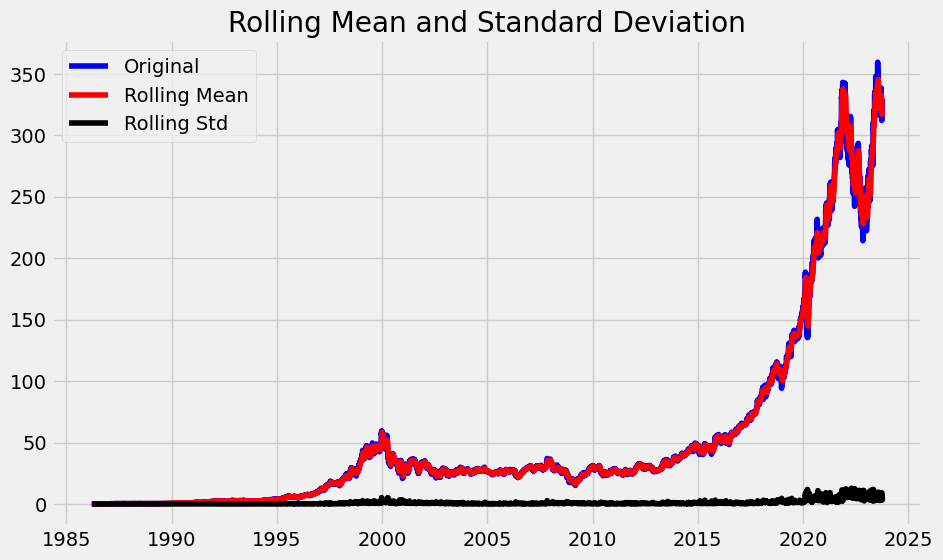

Results of ADF test
Test Statistics                   3.177752
p-value                           1.000000
No. of lags used                 38.000000
Number of observations used    9431.000000
critical value (1%)              -3.431044
critical value (5%)              -2.861847
critical value (10%)             -2.566933
dtype: float64


In [13]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of ADF test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for adft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

<Figure size 1000x600 with 0 Axes>

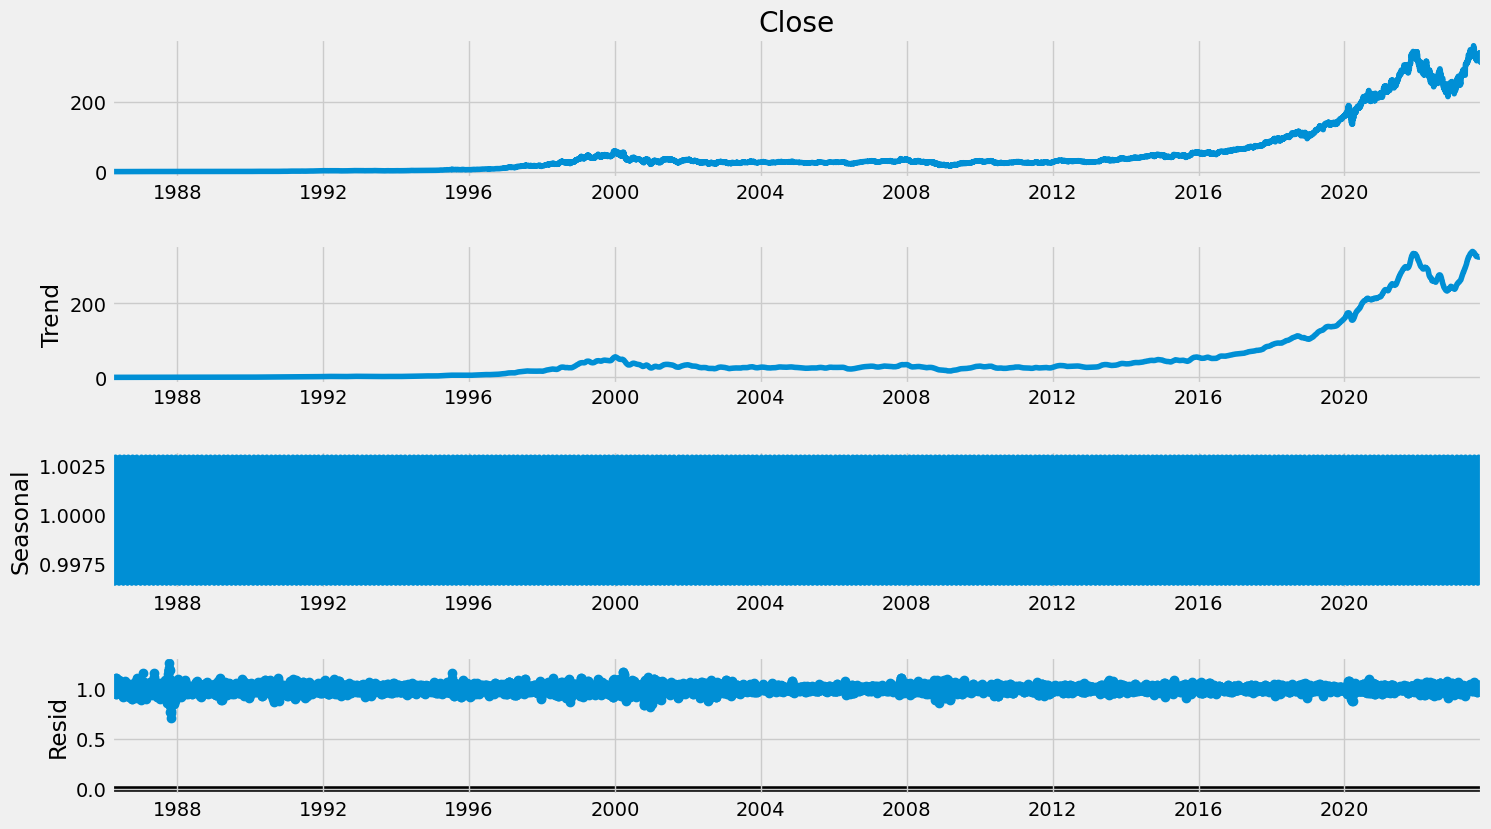

In [14]:
result = seasonal_decompose(df['Close'],model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


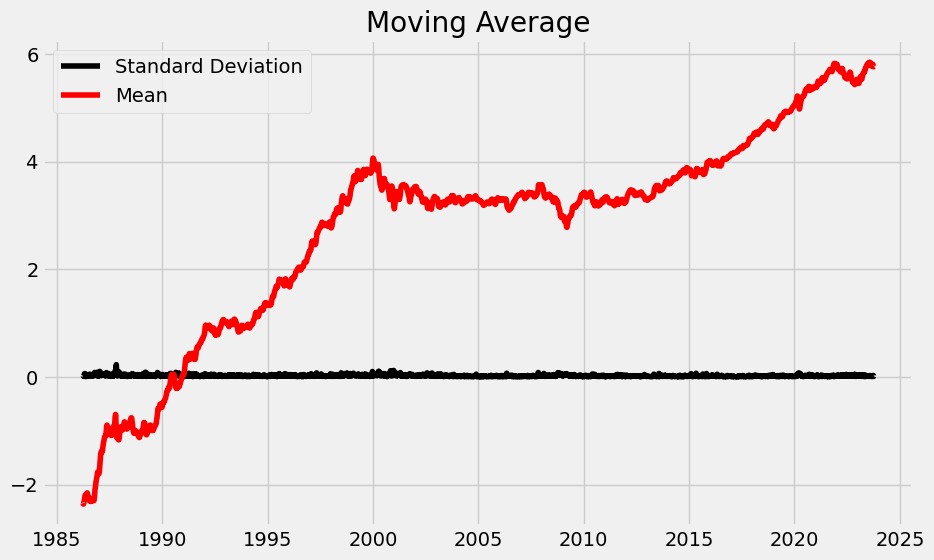

In [15]:
#if not stationary then eliminate trend
#Eliminate trend
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

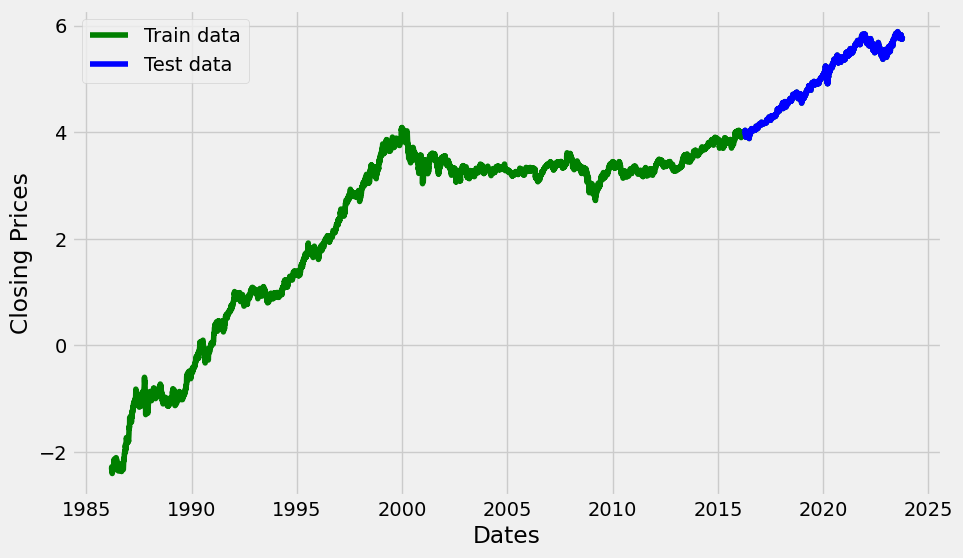

In [16]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36191.738, Time=2.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36190.271, Time=1.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-36190.293, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36183.026, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-36195.968, Time=4.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-36205.991, Time=1.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36203.810, Time=1.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-36207.417, Time=2.87 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36209.455, Time=1.42 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-36199.211, Time=1.19 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 17.505 seconds


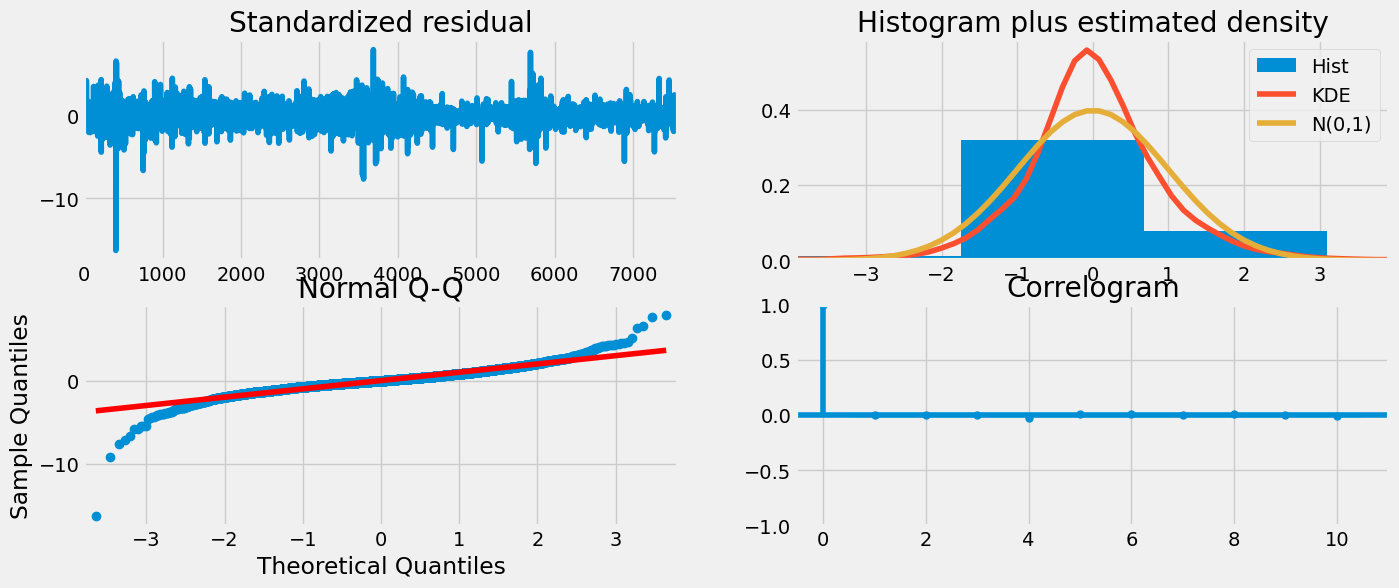

In [17]:
stepwise_fit = auto_arima(train_data,
                          start_p=0,
                          start_q=0,
                          test='adf',
                          max_p=3,
                          max_q=3,
                          m=1,
                          d=None,
                          seasonal=False,
                          start_P=0,
                          D=0,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()
stepwise_fit.plot_diagnostics(figsize=((15,6)))
plt.show()

In [18]:
model = ARIMA(train_data,order=(3,1,0))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 7573
Model:                 ARIMA(3, 1, 0)   Log Likelihood               18103.605
Date:                Wed, 01 Nov 2023   AIC                         -36199.211
Time:                        17:30:57   BIC                         -36171.482
Sample:                             0   HQIC                        -36189.693
                               - 7573                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0086      0.007      1.148      0.251      -0.006       0.023
ar.L2         -0.0436      0.006     -6.976      0.000      -0.056      -0.031
ar.L3         -0.0302      0.007     -4.582      0.0

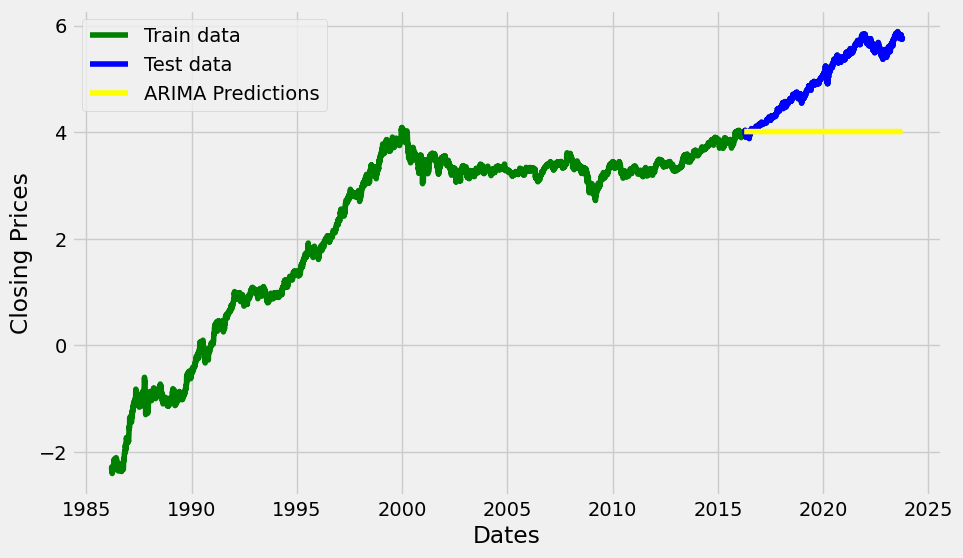

In [19]:
y_pred = fitted.get_forecast(len(test_data.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = fitted.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test_data.index
y_pred_out = y_pred_df["Predictions"] 
plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

In [20]:
fc = fitted.forecast(30,alpha=0.05)
fc

7573    4.010611
7574    4.010274
7575    4.010212
7576    4.010253
7577    4.010266
7578    4.010266
7579    4.010264
7580    4.010264
7581    4.010264
7582    4.010264
7583    4.010264
7584    4.010264
7585    4.010264
7586    4.010264
7587    4.010264
7588    4.010264
7589    4.010264
7590    4.010264
7591    4.010264
7592    4.010264
7593    4.010264
7594    4.010264
7595    4.010264
7596    4.010264
7597    4.010264
7598    4.010264
7599    4.010264
7600    4.010264
7601    4.010264
7602    4.010264
Name: predicted_mean, dtype: float64

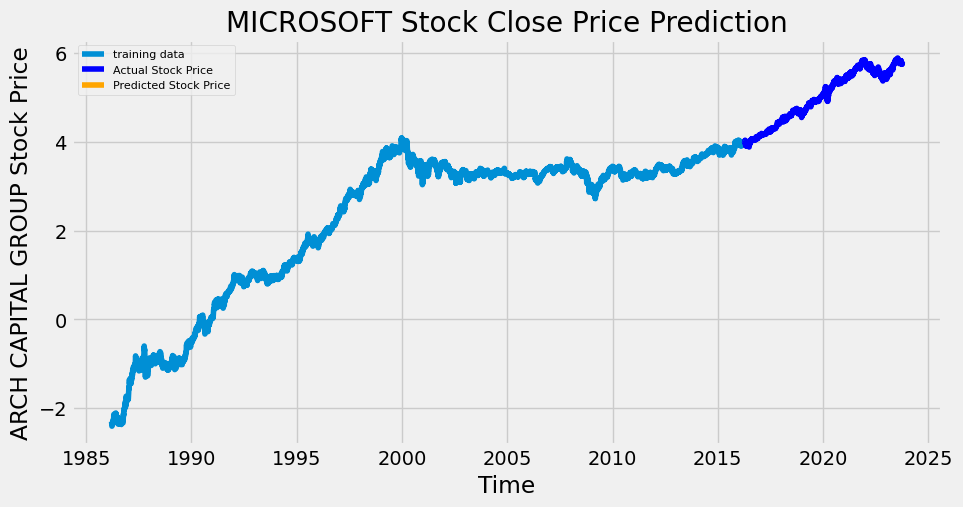

In [21]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('MICROSOFT Stock Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [22]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

ValueError: Found input variables with inconsistent numbers of samples: [1894, 30]